In [1]:
# %pip install scikit-learn
# %pip install wget
# %pip uninstall transformers -y
# %pip install einops
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124

In [2]:
# %pip install latexify-py
# %pip install soundfile

## <center> **SIREN**: Sinusoidal Representation Networks
###### <center> _Sitzmann, V., Martel, J., Bergman, A., Lindell, D., and Wetzstein, G. 2020. [Implicit Neural Representations with Periodic Activation Functions](https://www.vincentsitzmann.com/siren/). In Proc. NeurIPS._

## <center> Audio Mapping Function
### $$ f(t): \mathbb{R} \to \mathbb{R} $$

### $$ \text{Cordinate Map}: \mathbb{R} \to \mathbb{R} : [t] \to [A] $$
### $$ \text{Feature Map}: \mathbb{R}^{\text{features}} \to \mathbb{R} : [t_{1 \cdots k}] \to [A] $$
### $$ \text{Final Map}: \mathbb{R} \to \mathbb{R}^{\text{features}} \to \mathbb{R} : [t] \to [t_{1 \cdots k}] \to [A] $$

<div align = "center">
    <img src = "./SIREN/1.png" style="float: left; width: 50%">
    <img src = "./SIREN/2.png" style="width: 50%">
</div>

### Run **only in Colab or Linux** to install Latex Fonts and add `latexify.py` in the upload files

In [3]:
# % apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

# from latexify import latexify
# latexify(columns = 2)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile
import os
import wget

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cuda


### Get the Audio File

In [5]:
if os.path.exists('gt_bach.wav'):
    print('gt_bach.wav exists')
else:
    wget.download("https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav")

gt_bach.wav exists


In [6]:
from IPython.display import Audio
Audio('gt_bach.wav')

In [7]:
import torchaudio
audio, sr = torchaudio.load('./gt_bach.wav')

$$ \text{Sampling Frequency} = \frac{\text{No. of Samples}}{\text{Time Taken}} $$

In [8]:
print("Sampling rate", sr)

print(audio.shape)
audio = audio[0]

Sampling rate 44100
torch.Size([1, 308207])


In [9]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 6.988820861678004 seconds


In [10]:
audio

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0473, 0.0297, 0.0168])

In [11]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

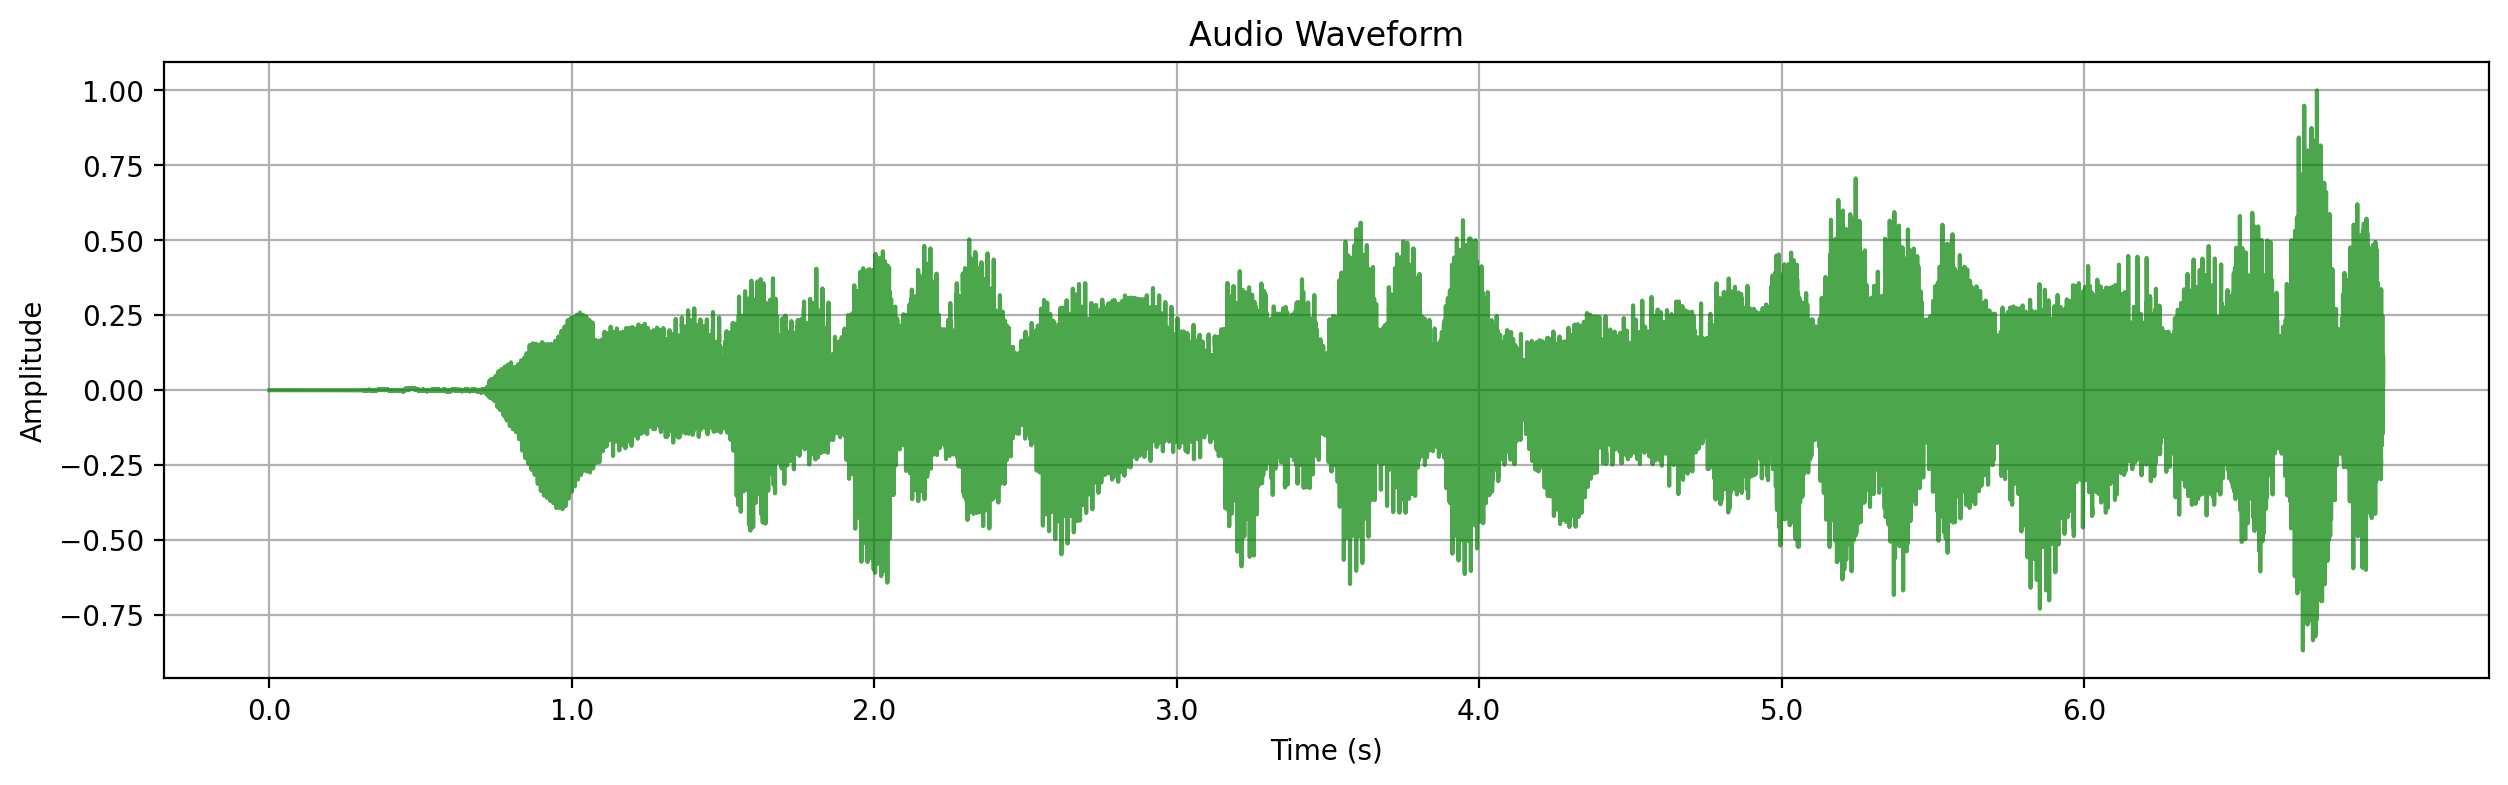

In [12]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

### Using the last 2 seconds of the Audio

In [13]:
audio = audio[-2 * sr:]
print(audio.shape)
print(audio)

torch.Size([88200])
tensor([-0.0099,  0.0410,  0.0865,  ...,  0.0473,  0.0297,  0.0168])


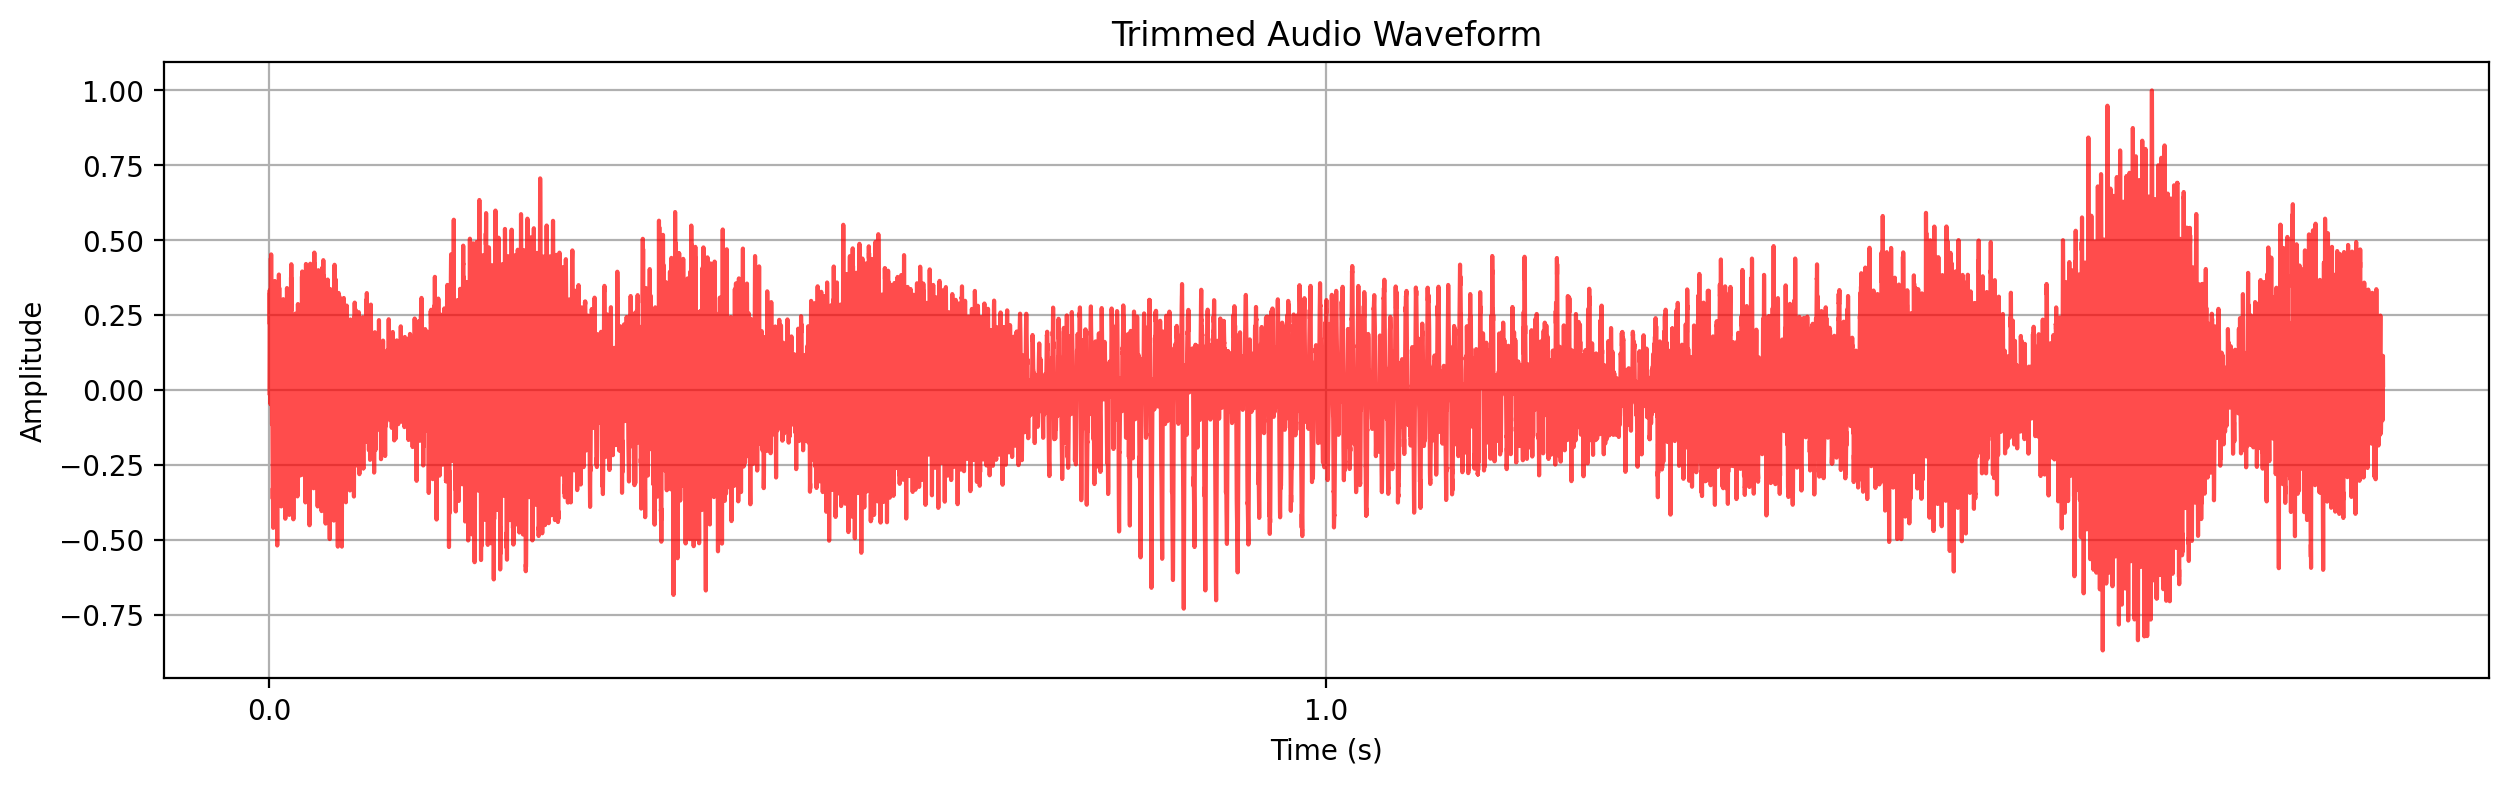

In [14]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

### Creating the Time Series $t = [-100.0, \cdots, 100.0]$ domain shifted to $[-100, 100]$

In [15]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([88200, 1])
tensor([[-100.0000],
        [ -99.9977],
        [ -99.9955],
        ...,
        [  99.9955],
        [  99.9977],
        [ 100.0000]])


In [16]:
Audio(audio, rate = sr)

### Gaussian Kernel and Random Fourier Features

#### The Gaussian Kernel
$$ K(\textbf{x}, \textbf{x}') = \exp{(-\gamma \lVert \textbf{x} - \textbf{x}' \rVert^2)}, \gamma = \frac{1}{2\sigma^2}$$

#### Since this is infinte dimensional, it can approximated with the **Fourier Transform** of this kernel
###### _(Rahimi, A., & Recht, B. (2007). [Random features for large-scale kernel machines](https://papers.nips.cc/paper_files/paper/2007/hash/013a006f03dbc5392effeb8f18fda755-Abstract.html). Advances in Neural Information Processing Systems, 1177–1184.)_

$$\gamma(\mathbf{v}) = [\cos({2 \pi \mathbf{B}\mathbf{v}}), \sin({2 \pi \mathbf{B}\mathbf{v}})]^T $$
$$ \mathbf{v} \in \mathbb{R}^{\text{input}} $$
Each entry in $\mathbf{B} \in \mathbb{R}^{m \times \text{input}}$ is sampled from $\mathcal{N}(0, \sigma^2 I)$
$$ \gamma(\mathbf{v}) = [a_1 \cos({2 \pi \mathbf{b}_1^T\mathbf{v}}), a_1 \sin({2 \pi \mathbf{b}_1^T\mathbf{v}}), \cdots, a_m \cos({2 \pi \mathbf{b}_m^T\mathbf{v}}), a_m \sin({2 \pi \mathbf{b}_m^T\mathbf{v}})]^T $$

In [17]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [18]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([88200, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0050, -0.0194, -0.0189,  ..., -0.0198,  0.0093, -0.0090],
        [ 0.0011, -0.0200, -0.0189,  ..., -0.0199,  0.0113, -0.0124],
        ...,
        [-0.0141, -0.0200, -0.0148,  ...,  0.0045, -0.0043, -0.0085],
        [-0.0110, -0.0196, -0.0146,  ...,  0.0057, -0.0019, -0.0119],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


## Fit a Linear Model over this expanded feature domain
### $\textbf{X}_{(88200, 5000)}, \textbf{y}_{(88200, )}$

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


### On saving the model weights and sound file

In [20]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [21]:
print(pred_audio)
print(audio)

[-0.0858483  -0.05092815 -0.01508471 ... -0.09002545 -0.10920331
 -0.1290876 ]
tensor([-0.0099,  0.0410,  0.0865,  ...,  0.0473,  0.0297,  0.0168])


### Reconstruction Losses ($L_1$ and $L_2$)
$$ L_1 = \lVert \text{Reconstructed} - \text{Original} \rVert_1 $$
$$ L_2 = \lVert \text{Reconstructed} - \text{Original} \rVert_2 $$

In [22]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(np.float32(40.090504), np.float32(9472.861))

## Reconstructed Audio

In [23]:
Audio(pred_audio, rate = sr)

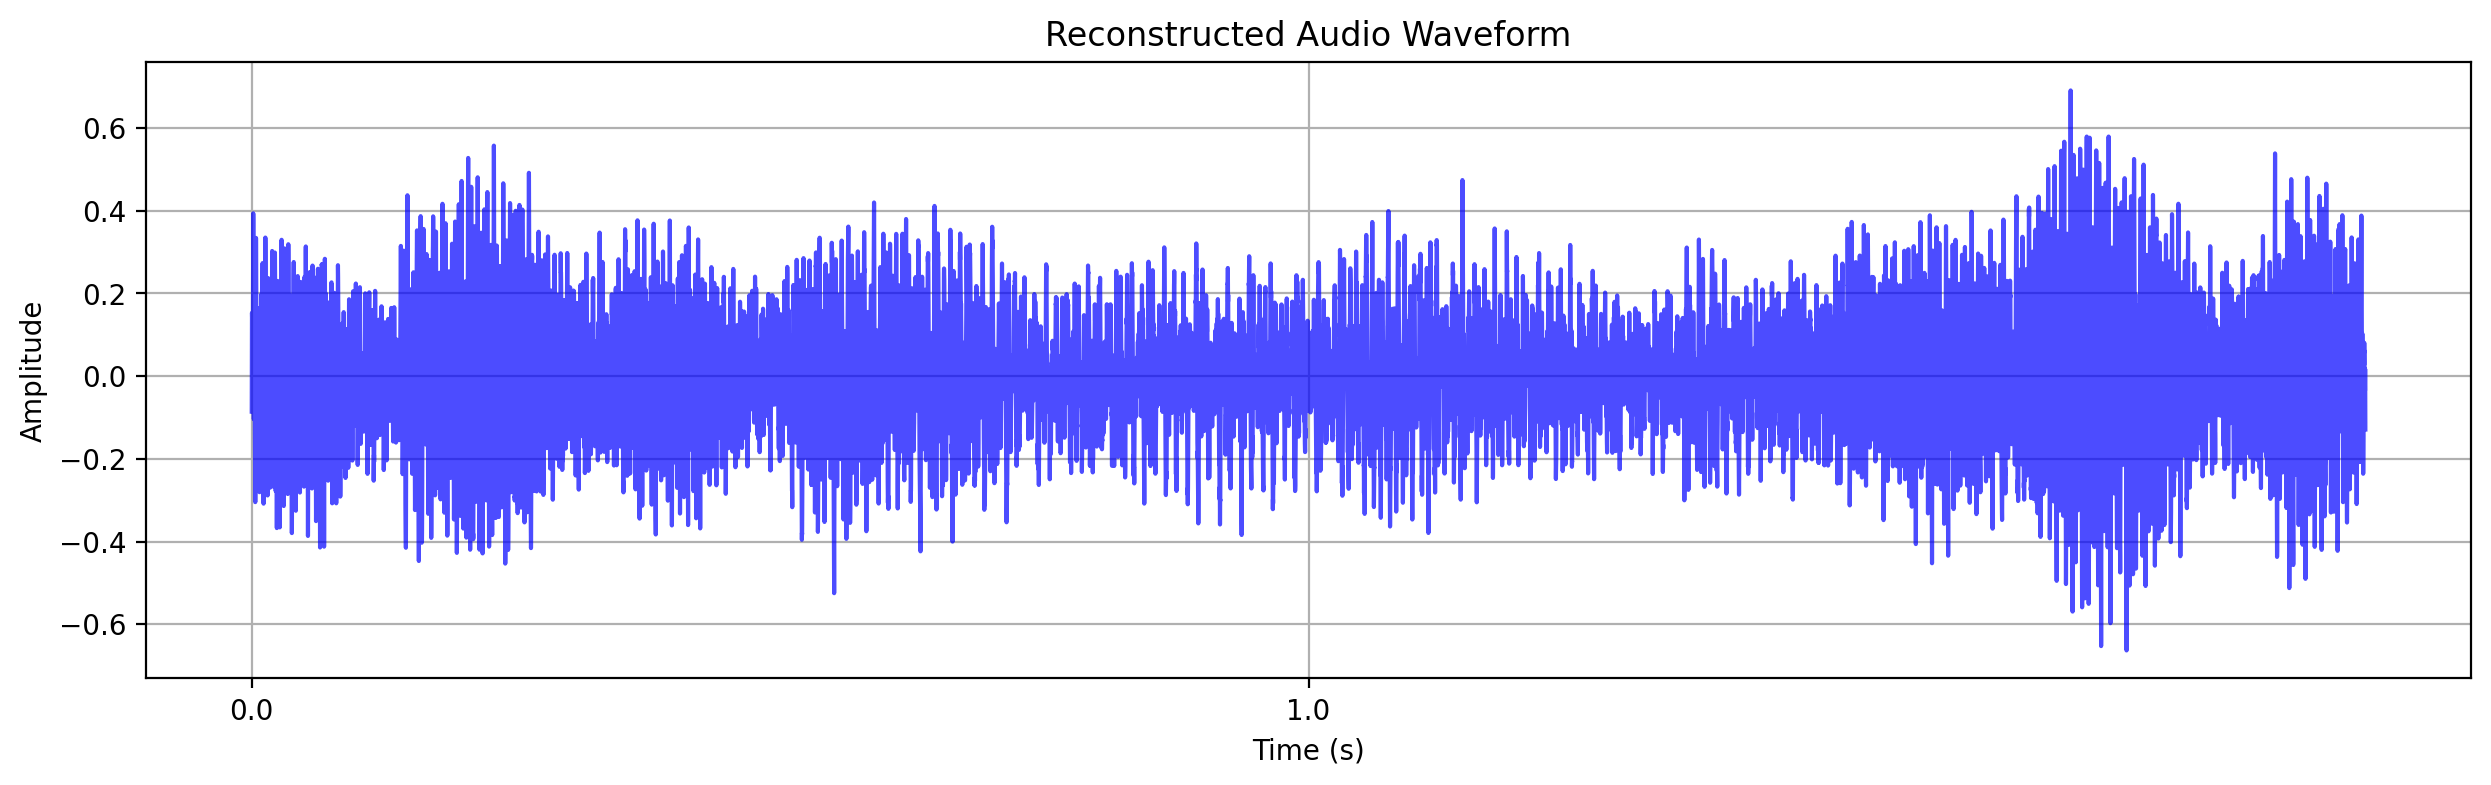

In [24]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

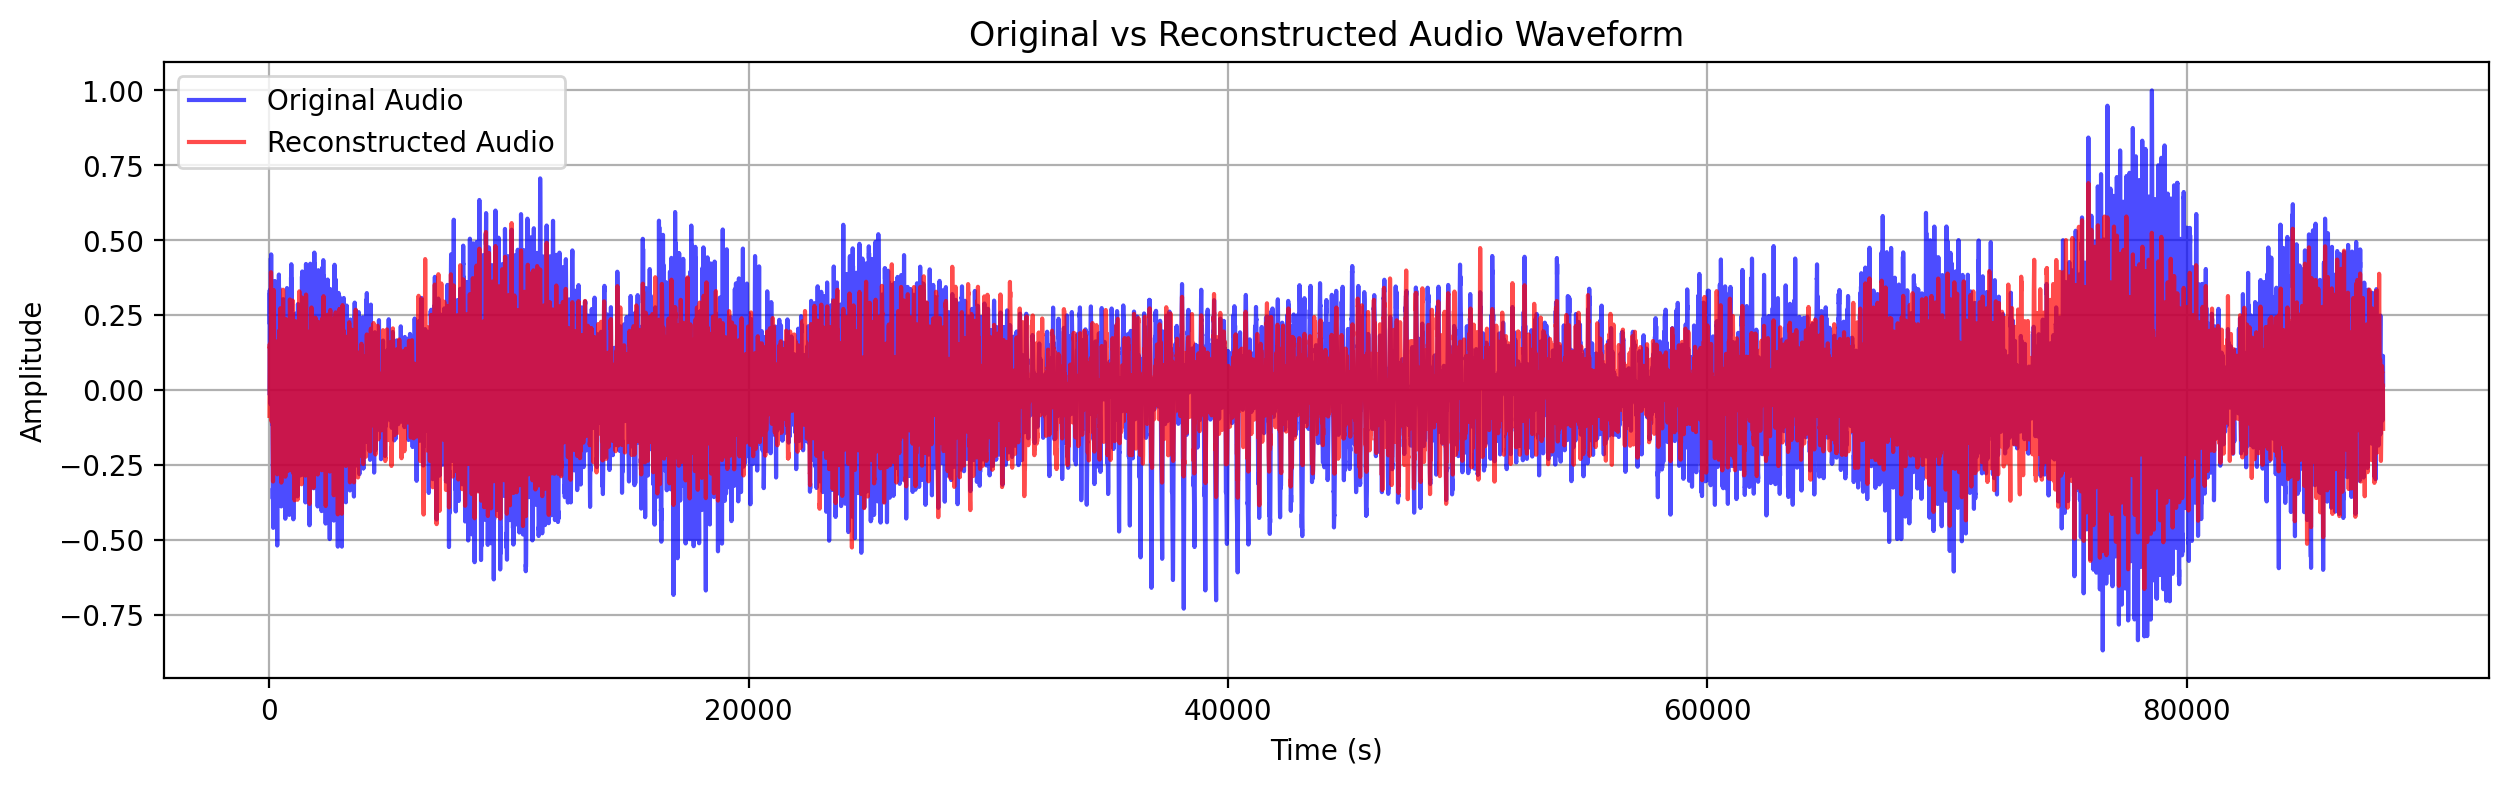

In [25]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [29]:
def compute_rmse(original_signal, reconstructed_signal):
    """
    Compute the Root Mean Squared Error (RMSE) between original and reconstructed signals.
    Convert inputs to NumPy float64 arrays for consistency.
    """
    if isinstance(original_signal, torch.Tensor):  # we Convert audio if it is in torch tensor to numpy
        original_signal = original_signal.cpu().numpy()
    original_signal = np.asarray(original_signal, dtype=np.float64)
    
    reconstructed_signal = np.asarray(reconstructed_signal, dtype=np.float64)
    
    error = original_signal - reconstructed_signal
    squared_error = np.square(error)
    mean_squared_error = np.mean(squared_error)
    rmse = np.sqrt(mean_squared_error)
    
    return rmse


def compute_snr(original_signal, reconstructed_signal):
    """
    Compute the Signal-to-Noise Ratio (SNR) in dB between original and reconstructed signals.
    Convert inputs to NumPy float64 arrays for consistency.
    """
    if isinstance(original_signal, torch.Tensor):
        original_signal = original_signal.cpu().numpy()  # Convert torch tensor to numpy
    original_signal = np.asarray(original_signal, dtype=np.float64)
    
    reconstructed_signal = np.asarray(reconstructed_signal, dtype=np.float64)
    
    signal_power = np.mean(original_signal ** 2)
    noise_power = np.mean((original_signal - reconstructed_signal) ** 2)
    
    if noise_power == 0:
        return np.inf  # Perfect reconstruction
    return 10 * np.log10(signal_power / noise_power)

In [26]:
rmse = compute_rmse(audio, pred_audio)
snr = compute_snr(audio, pred_audio)

print(f"RMSE: {rmse}")
print(f"SNR: {snr} dB")


RMSE: 0.13499175608024344
SNR: 3.7854355810608205 dB


### Interpolation

#### We remove out 10,000 continuous samples from the time series
#### $\textbf{X}_{(:\text{start}, 5000) \cup (\text{end}:, 5000)}, \textbf{y}_{(:\text{start},) \cup (\text{end}:,)}$

<div align = "center">
    <img src = "./SIREN/3.png" style="width: 65%;">
</div>

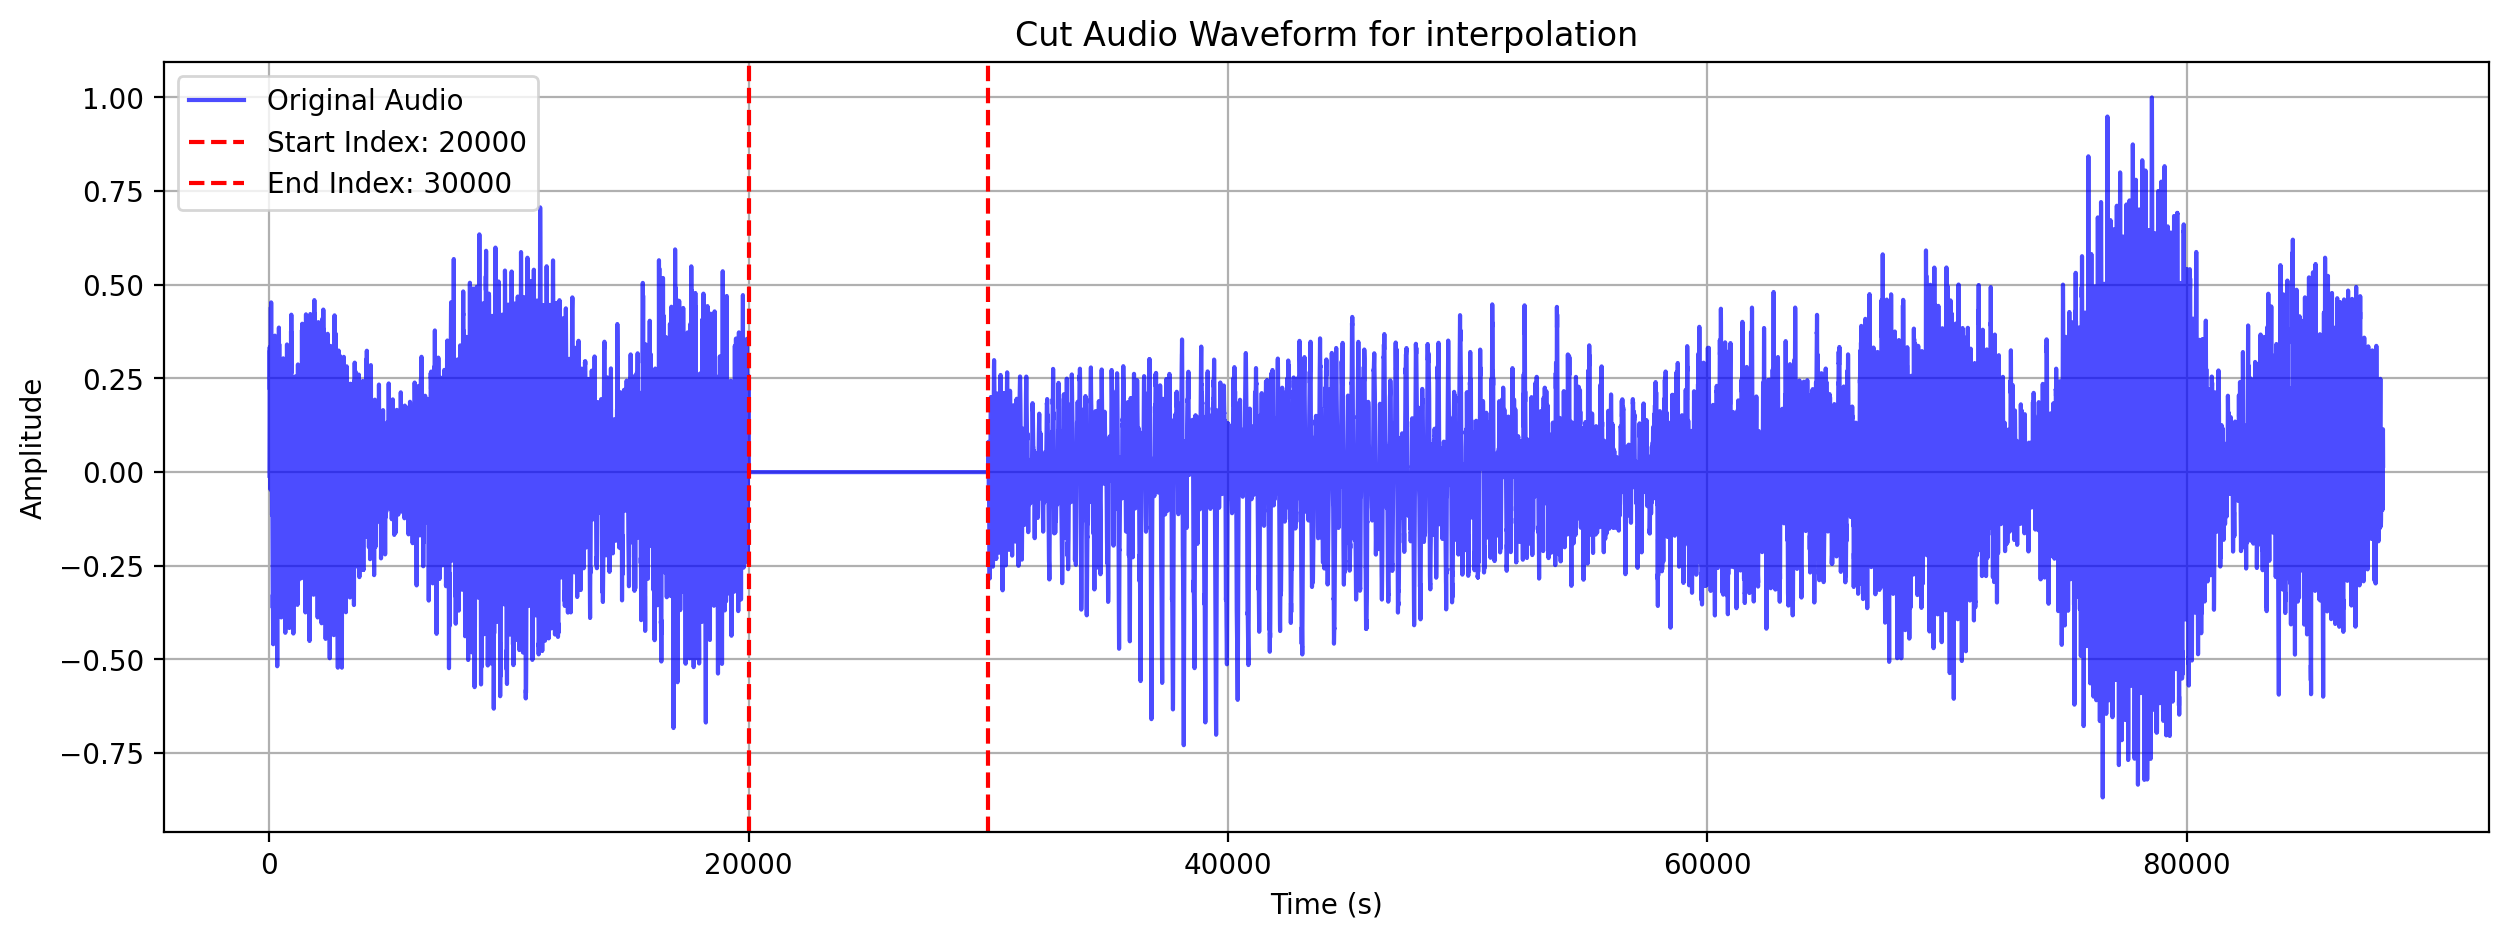

In [19]:
start_idx = 20000
end_idx = 30000

audio_new = audio.clone()
audio_new[start_idx : end_idx] = 0

plt.figure(figsize=(15, 5))
plt.plot(audio_new, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.axvline(start_idx, color = 'red', linestyle = '--', label = f'Start Index: {start_idx}')
plt.axvline(end_idx, color = 'red', linestyle = '--', label = f'End Index: {end_idx}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Cut Audio Waveform for interpolation')
plt.grid()
plt.legend()
plt.show()

#### Extract out the $\textbf{X}[:\text{start}]$ $\textbf{X}[\text{end}:]$, $\textbf{y}[:\text{start}]$  $\textbf{y}[\text{end}:]$ and then concatentate them

In [20]:
X_rff1 = X_rff[:start_idx]
X_rff2 = X_rff[end_idx:]

audio1 = audio[:start_idx]
audio2 = audio[end_idx:]

# concate X_rff1 and X_rff2
X_rffF = torch.cat((X_rff1, X_rff2), dim = 0)

# concate audio1 and audio2
audioF = torch.cat((audio1, audio2), dim = 0)

In [21]:
print(X_rffF.shape)
print(audioF.shape)

torch.Size([78200, 5000])
torch.Size([78200])


### Fit the Linear model on the left out portion `X_rffF`

In [22]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rffF.numpy(), audioF)

LinearRegression()

### But predict on the entire `X_rff`

In [23]:
pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


In [24]:
print(pred_audio)
print(audio)

[ 0.0670938   0.08818335  0.109065   ... -0.09982591 -0.11278635
 -0.12509066]
tensor([-0.0099,  0.0410,  0.0865,  ...,  0.0473,  0.0297,  0.0168])


In [25]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(np.float32(51.423897), np.float32(10828.656))

### Interpolated Audio

In [26]:
Audio(pred_audio, rate = sr)

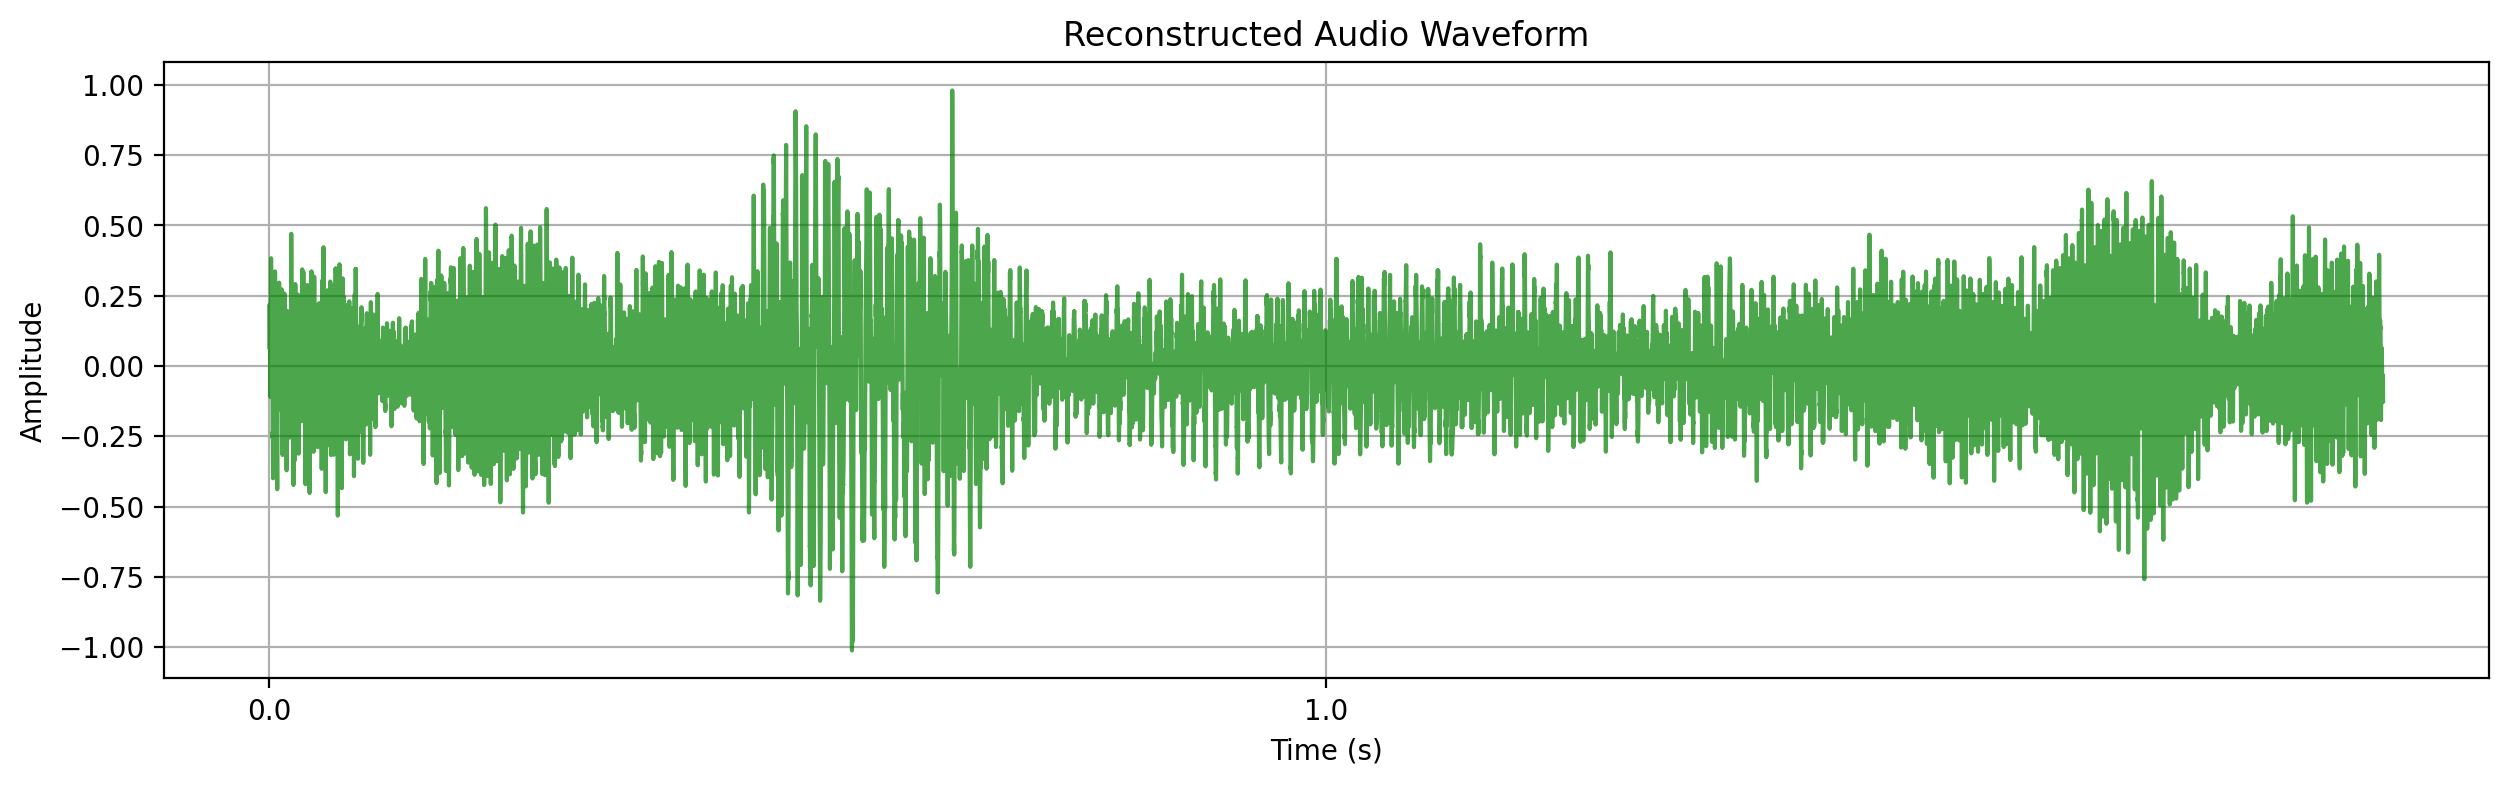

In [27]:
audio_plot(pred_audio, sr, 'green', 'Reconstructed Audio Waveform')

### Comparison of original waveform to interpolated reconstructed audio

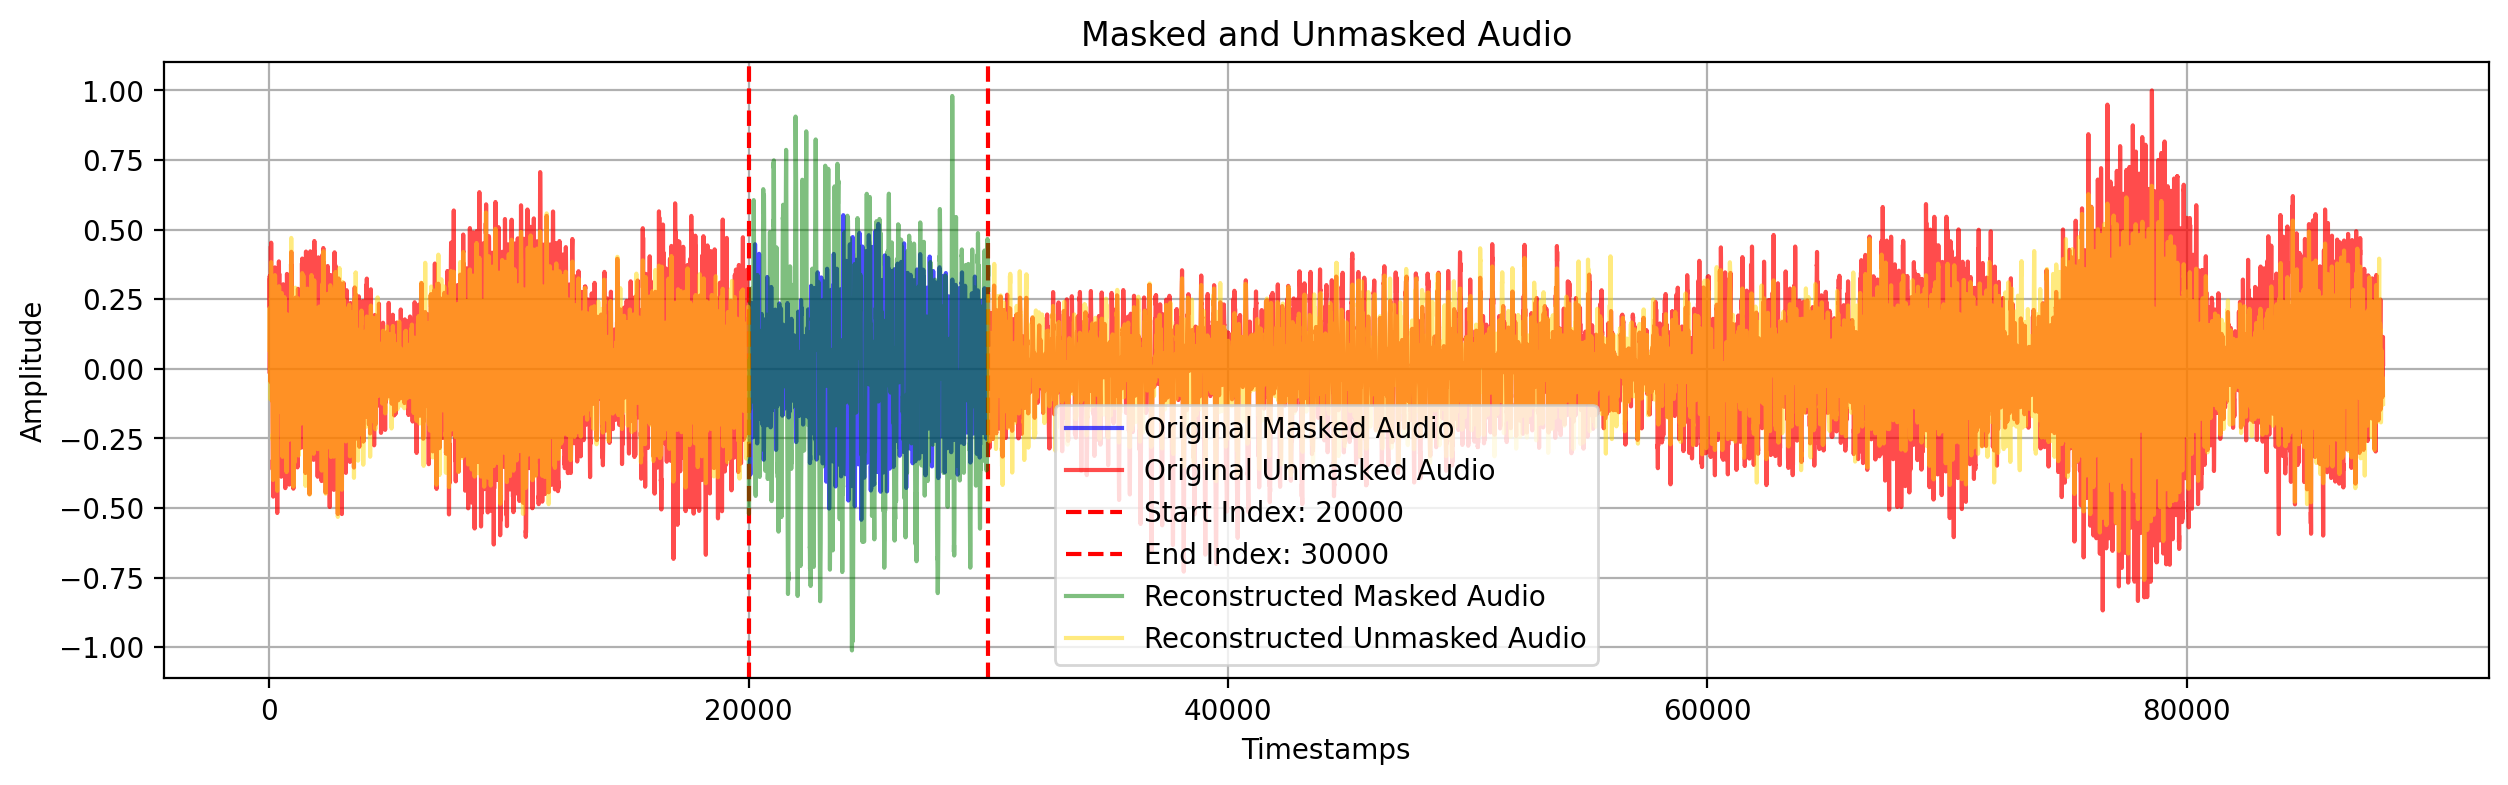

In [28]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(start_idx,end_idx), audio[start_idx:end_idx].numpy(), color = 'blue', alpha = 0.7, label = 'Original Masked Audio')
plt.plot(np.arange(start_idx), audio[:start_idx], color = 'red', alpha = 0.7, label = 'Original Unmasked Audio')
plt.plot(np.arange(end_idx, X.shape[0]), audio[end_idx:], color = 'red', alpha = 0.7)

plt.axvline(start_idx, color = 'red', linestyle = '--', label = f'Start Index: {start_idx}')
plt.axvline(end_idx, color = 'red', linestyle = '--', label = f'End Index: {end_idx}')

plt.plot(np.arange(start_idx,end_idx), pred_audio[start_idx : end_idx], color = 'green', alpha = 0.5, label = 'Reconstructed Masked Audio')
plt.plot(np.arange(start_idx), pred_audio[:start_idx], color = 'gold', alpha = 0.5, label = 'Reconstructed Unmasked Audio')
plt.plot(np.arange(end_idx, X.shape[0]), pred_audio[end_idx:], color = 'gold', alpha = 0.5)

plt.xlabel('Timestamps')
plt.ylabel('Amplitude')
plt.title('Masked and Unmasked Audio')
plt.grid()
plt.legend()
plt.show()

In [30]:
rmse = compute_rmse(audio[start_idx:end_idx].numpy(), pred_audio[start_idx : end_idx])
snr = compute_snr(audio[start_idx:end_idx].numpy(), pred_audio[start_idx : end_idx])

print(f"RMSE: {rmse}")
print(f"SNR: {snr} dB")


RMSE: 0.37414406050383975
SNR: -5.504096604122973 dB
